In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams['axes.grid'] = False
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})


In [4]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams['axes.grid'] = False
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

import numpy as np
import itertools
import pandas as pd
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import InputLayer
from keras.layers import Dense
import neptune.new as neptune
from datetime import datetime
from keras_visualizer import visualizer

import os
os.environ["PATH"] += os.pathsep + 'C:/Users/suprabhashsahu/Desktop/StrategyResearch/venv/Graphviz/bin/'

from Utils.add_features import add_fisher
from Data.data_retrieval import get_data
from Utils.neptune_ai_api_key import API_KEY

np.random.seed(12)

In [36]:
def get_stock_data(symbol):
    if symbol == 'sinx':
        df = get_data(".NSEI", 'D')
        df.drop(columns=["Volume"], inplace=True)
        df["Close"] = df["Open"] = df["High"] = df["Low"] = np.sin(df.index / 10 ) +2
    else:
        df = get_data(symbol, 'D')
    df.set_index("Datetime", inplace=True)
    df.dropna(inplace=True)
    return df

def f_discretize(values, num_states=10):
    states_value = dict()
    step_size = 1./num_states
    for i in range(num_states):
        if i == num_states - 1:
            states_value[i] = values.max()
        else:
            states_value[i] = values.quantile((i+1)*step_size)
    return states_value

def value_to_state(value, states_value):
    if np.isnan(value):
        return np.nan
    else:
        for state, v in states_value.items():
            if value <= v:
                return str(state)
        return str(state)

def add_features(df, features):
    lookbacks = []
    all_states = []
    for feature, lookback, discretize in [(feature["feature"], feature["lookback"], feature["discretize"]) for feature in features]:
        lookbacks.append(lookback)
        if feature == "Close":
            if discretize>0:
                states = f_discretize(df["Close"].iloc[lookback:int(df.shape[0]*0.8)], discretize)
                df[f"{feature}_state"] = df['Close'].apply(lambda x : value_to_state(x, states))
        if feature.startswith("Fisher"):
            df[feature] = add_fisher([df, lookback])[[f"Fisher{lookback}"]]
            if discretize>0:
                states = f_discretize(df[feature].iloc[lookback:int(df.shape[0]*0.8)], discretize)
                df[f"{feature}_state"] = df[feature].apply(lambda x : value_to_state(x, states))
        if feature.startswith("Momentum"):
            df[feature] = df["Close"].diff(lookback)
            if discretize>0:
                states = f_discretize(df[feature].iloc[lookback:int(df.shape[0]*0.8)], discretize)
                df[f"{feature}_state"] = df[feature].apply(lambda x : value_to_state(x, states))
        try:
            all_states.append({'Feature': feature, 'states':states})
        except:
            pass

    df = df.iloc[max(lookbacks):]
    return df, all_states

def get_model(num_states, num_actions):
    model = Sequential()
    model.add(InputLayer(batch_input_shape=(1, num_states)))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(num_actions, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    return model

def plot_performance(prices, actions_history, equity_curve):
    # fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 7))
    fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(15, 7))
    ax1.plot(prices, label='Close')
    ax1_copy = ax1.twinx()
    ax1_copy.plot(actions_history, label='Actions')
    # ax2.plot(actions_history, label='Actions')
    # ax2_copy = ax2.twinx()
    # for feature in [feature["feature"] for feature in features]:
    #     ax2_copy.plot(df[feature], label=feature, color='green', ls='dotted')
    # ax2_copy.axhline(0.0, ls='--', color='grey')
    ax3.plot(equity_curve, label='Net worth')
    ax3.plot([price*10000 / prices[0] for price in prices], label='Benchmark')
    ax1.legend()
    # ax2.legend()
    ax3.legend()
    plt.show()

def train_q_learning(train, state_lookback, model, alpha, epsilon, gamma, episodes, all_states, all_actions, metric="absolute"):

    train_df = train.copy()
    train_data = train_df[["Close", "state"]]

    arr = np.empty(shape=(0,len(all_states)))
    for i, val in enumerate(np.array(train_data)):
        if i<state_lookback:
            arr = np.vstack((arr, np.empty(shape=(1,len(all_states)))))
            continue
        current_adj_close, state = val
        state = int(state)
        arr = np.vstack((arr,np.identity(len(all_states))[state:state + 1]))

    for ii in tqdm(range(episodes)):

        #Backtester initialisation
        balance = 10000
        net_worth = balance
        in_position = False
        position_value = 0.0
        price_bought = 0.0
        bet_bought = 0.0
        actions_history = []
        equity_curve = []
        rewards = []
        states = []
        next_states = []
        prices = []
        current_q_all_states = []
        next_q_all_states = []

        q = model.predict(arr)
        actions = (-1*q).argsort()

        for i, val in enumerate(np.array(train_data)):
            if i<state_lookback:
                continue
            current_adj_close, state = val
            prices.append(current_adj_close)
            prev_adj_close, _ = np.array(train_data)[i - 1]
            states.append(arr[i])  #Needs to be changed for historical states>1
            current_q_all_states.append(q[i])

            # decide action
            if epsilon > 0.1:
                epsilon = epsilon / 1.2

            if np.random.uniform(0, 1) < epsilon:
                action_priority = np.arange(0,len(all_actions))
                np.random.shuffle(action_priority)
            else:
                action_priority = actions[i]

            action = action_priority[0]
            actions_history.append(action)

            if not in_position:
                if action == 1:  # OPEN LONG
                    in_position = True
                    price_bought = current_adj_close
                    bet_bought = balance
                    balance -= bet_bought
                    position_value = bet_bought
                    rewards.append(0)
                else:  # KEEP LOOKING
                    rewards.append(0)
            else:
                market_return = ((current_adj_close - price_bought) / price_bought)
                if action == 1:  # HOLD LONG
                    position_value = bet_bought * (1.0 + market_return)
                    if metric=="absolute":
                        rewards.append(bet_bought*market_return)
                    else:
                        rewards.append(market_return)
                else:  # CLOSE LONG
                    balance += bet_bought * (1.0 + market_return)
                    in_position = False
                    price_bought = 0.0
                    bet_bought = 0.0
                    position_value = 0.0
                    rewards.append(0)

            net_worth = balance + position_value
            equity_curve.append(net_worth)

            try:
                next_states.append(int(np.array(train_data)[i + 1][1]))
                next_q_all_states.append(q[i+1])
            except:
                break

        arr_fit_X = np.empty(shape=(0,len(all_states)))
        arr_fit_Y = np.empty(shape=(0,len(all_actions)))
        for state, action, reward, next_state, cq, nq in zip(states, actions_history, rewards, next_states, current_q_all_states, next_q_all_states):
            target = ((1. - alpha) * cq[action]) + alpha * (reward + gamma * np.max(nq))
            cq[action] = target
            arr_fit_X = np.vstack((arr_fit_X,state))
            arr_fit_Y = np.vstack((arr_fit_Y,cq.reshape(-1, len(all_actions))))

        model.fit(arr_fit_X,arr_fit_Y,epochs=10, verbose=0)
        episode_return = equity_curve[-1]/equity_curve[0]-1
        print(f"Episode Number: {ii+1}, Total return of episode: {episode_return}")
        plot_performance(prices, actions_history, equity_curve)

    return model

def eval_q_learning(test_data, model, state_lookback):

    test_data = test_data[["Close", "state"]]

    arr = np.empty(shape=(0,len(all_states)))
    for i, val in enumerate(np.array(test_data)):
        if i<state_lookback:
            arr = np.vstack((arr, np.empty(shape=(1,len(all_states)))))
            continue
        current_adj_close, state = val
        state = int(state)
        arr = np.vstack((arr,np.identity(len(all_states))[state:state + 1]))

    #Backtester initialisation
    balance = 10000
    in_position = False
    position_value = 0.0
    price_bought = 0.0
    bet_bought = 0.0
    actions_history = []
    equity_curve = []
    rewards = []
    states = []
    prices = []
    current_q_all_states = []

    q = model.predict(arr)
    actions = (-1*q).argsort()

    for i, val in enumerate(np.array(test_data)):
        if i<state_lookback:
            continue
        current_adj_close, state = val
        prices.append(current_adj_close)
        prev_adj_close, _ = np.array(test_data)[i - 1]
        states.append(arr[i])
        current_q_all_states.append(q[i])
        action_priority = actions[i]

        action = action_priority[0]
        actions_history.append(action)

        if not in_position:
            if action == 1:  # OPEN LONG
                in_position = True
                price_bought = current_adj_close
                bet_bought = balance
                balance -= bet_bought
                position_value = bet_bought
                rewards.append(0)
            else:  # KEEP LOOKING
                rewards.append(0)
        else:
            market_return = ((current_adj_close - price_bought) / price_bought)
            if action == 1:  # HOLD LONG
                position_value = bet_bought * (1.0 + market_return)
                if metric=="absolute":
                    rewards.append(bet_bought*market_return)
                else:
                    rewards.append(market_return)
            else:  # CLOSE LONG
                balance += bet_bought * (1.0 + market_return)
                in_position = False
                price_bought = 0.0
                bet_bought = 0.0
                position_value = 0.0
                rewards.append(0)

        net_worth = balance + position_value
        equity_curve.append(net_worth)
    plot_performance(prices, actions_history, equity_curve)

# Data Prep

Get data

In [37]:
df = get_stock_data('sinx')
train_len = int(df.shape[0]*0.8)

Add Features

In [38]:
features = [
        {"feature": "Close", "lookback": 0, "discretize": 10},
        {"feature": "Momentum", "lookback": 1, "discretize": 10}
    ]
df, all_states = add_features(df, features)


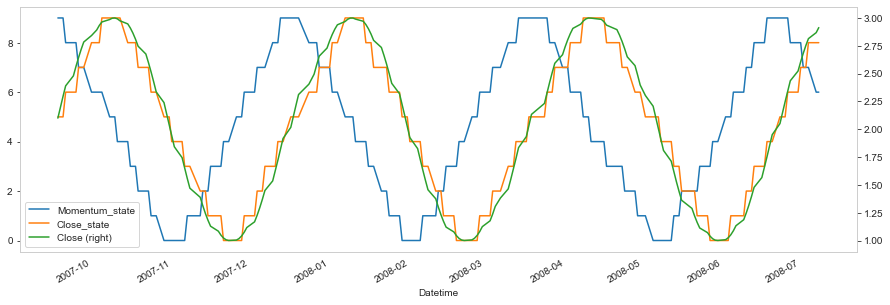

In [39]:
df["Close_state"] = df["Close_state"].astype(int)
df["Momentum_state"] = df["Momentum_state"].astype(int)
df[["Momentum_state", "Close_state", "Close"]].iloc[:200].plot(secondary_y="Close")
df["Close_state"] = df["Close_state"].astype(str)
df["Momentum_state"] = df["Momentum_state"].astype(str)

In [40]:
df["state"] = df[[f"{feature['feature']}_state" for feature in features]].agg(''.join, axis=1)
states = [list(state['states']) for state in all_states]
all_states = list(itertools.product(*states))
all_states = [''.join(tuple([str(state) for state in all_state])) for all_state in all_states]

all_states_dict = {}
for i, state in enumerate(all_states):
    all_states_dict[state] = i

df.replace({"state": all_states_dict}, inplace=True)

In [41]:
train_df = df.iloc[:train_len, :]
test_df = df.iloc[train_len:, :]

# Deep QLearning

In [42]:
all_actions = {0: 'neutral', 1: 'long'}
model = get_model(len(all_states), len(all_actions))
# visualizer(model, format='png', view=True)

In [43]:
alpha = 0.1
epsilon = 0.5
gamma = 0.5
episodes = 100
metric = "percent"
state_lookback = 1

  0%|          | 0/100 [00:00<?, ?it/s]

Episode Number: 1, Total return of episode: 4.343965788166718


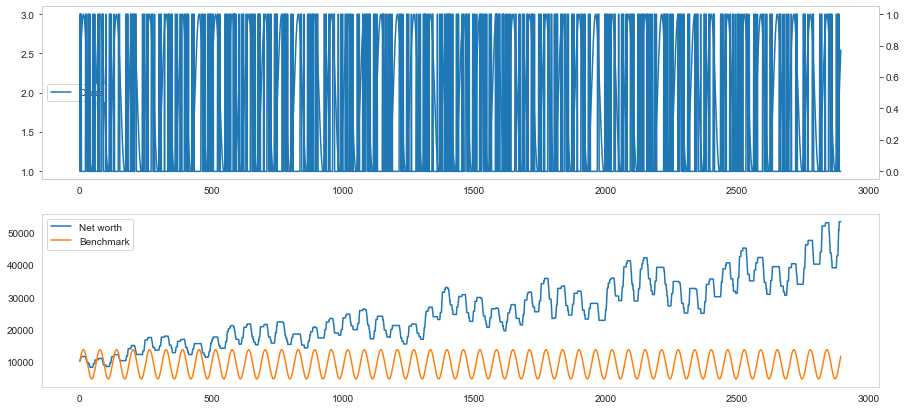

  1%|          | 1/100 [00:02<04:26,  2.69s/it]

Episode Number: 2, Total return of episode: 0.8100067687547854


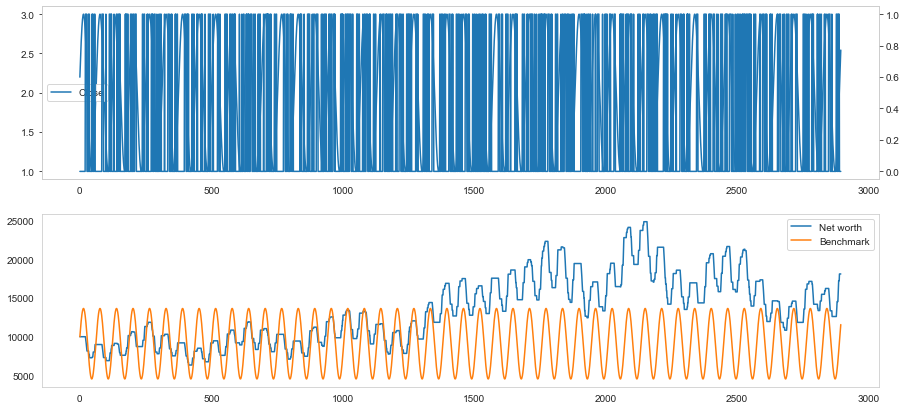

  2%|▏         | 2/100 [00:05<04:07,  2.52s/it]

Episode Number: 3, Total return of episode: 7.2668293015655205


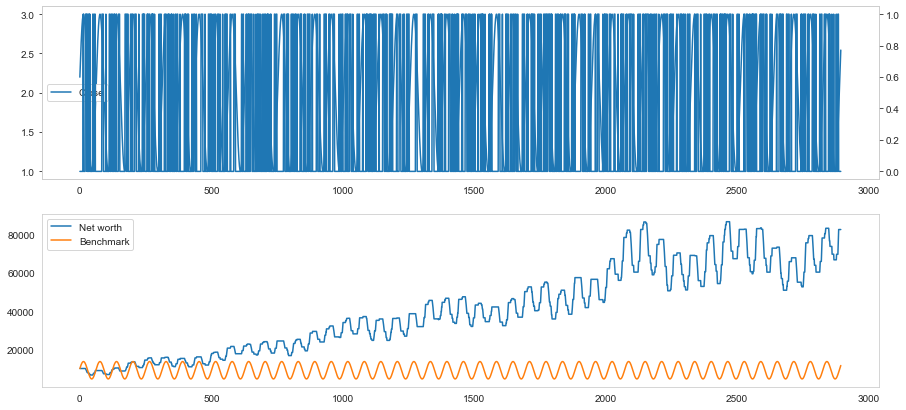

  3%|▎         | 3/100 [00:07<03:57,  2.45s/it]

Episode Number: 4, Total return of episode: 8.579475552946665


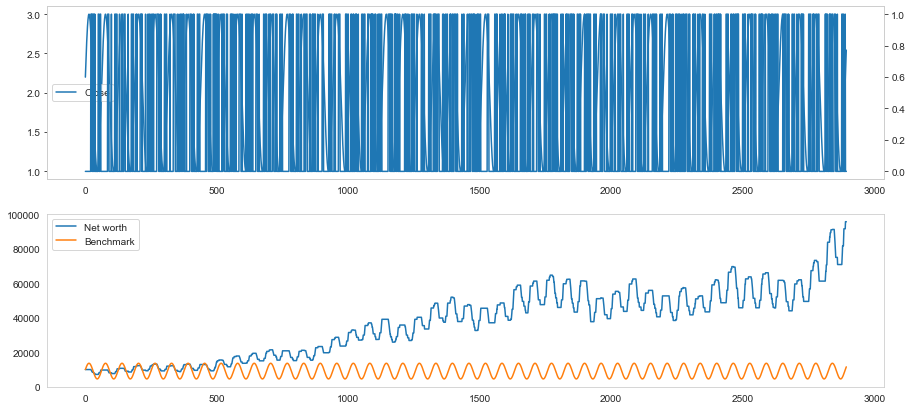

  4%|▍         | 4/100 [00:09<03:52,  2.42s/it]

Episode Number: 5, Total return of episode: 555.9229325789554


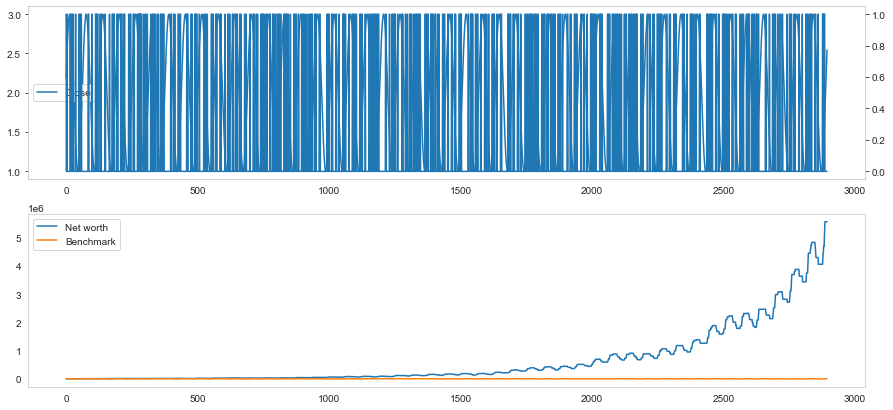

  5%|▌         | 5/100 [00:12<03:50,  2.42s/it]

Episode Number: 6, Total return of episode: 803.2726150382059


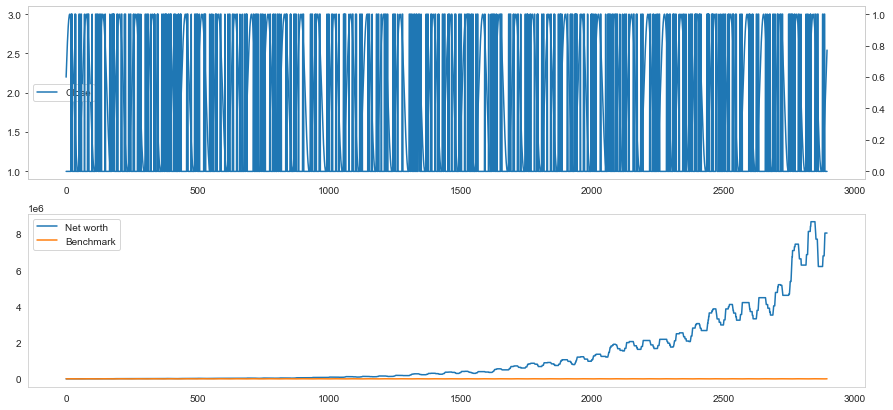

  6%|▌         | 6/100 [00:14<03:55,  2.50s/it]

Episode Number: 7, Total return of episode: 844.1808823839024


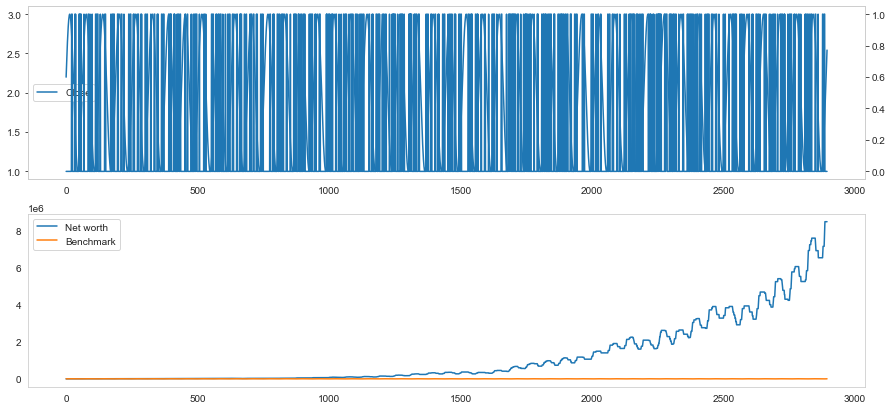

  7%|▋         | 7/100 [00:17<03:51,  2.49s/it]

Episode Number: 8, Total return of episode: 1532.1882814016471


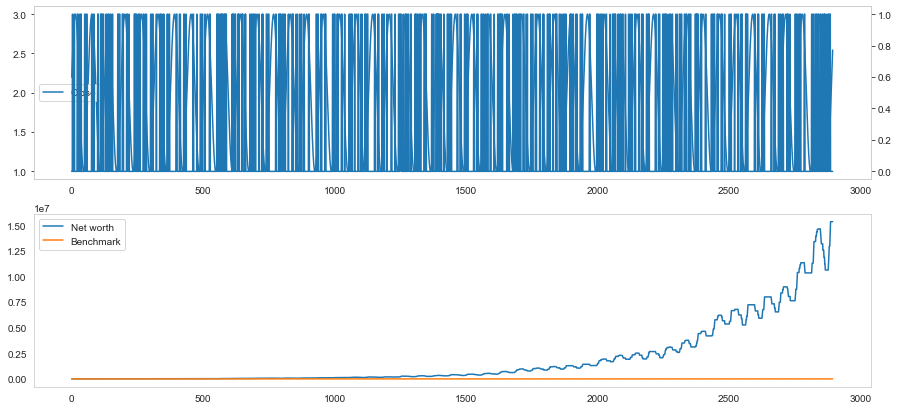

  8%|▊         | 8/100 [00:19<03:47,  2.48s/it]

Episode Number: 9, Total return of episode: 832.6040954489447


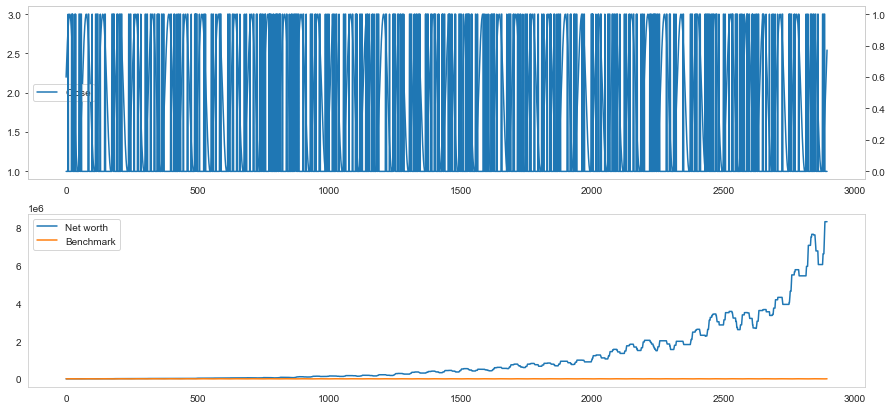

  9%|▉         | 9/100 [00:22<03:44,  2.46s/it]

Episode Number: 10, Total return of episode: 112.44328546928


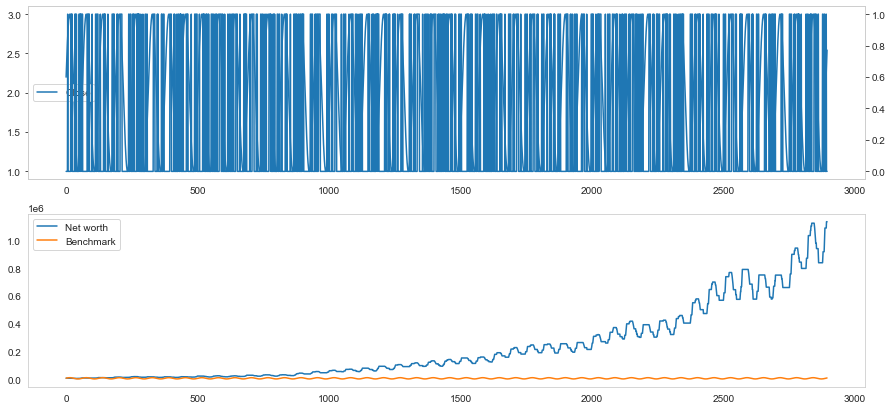

 10%|█         | 10/100 [00:24<03:42,  2.47s/it]

Episode Number: 11, Total return of episode: 1701.7036123931416


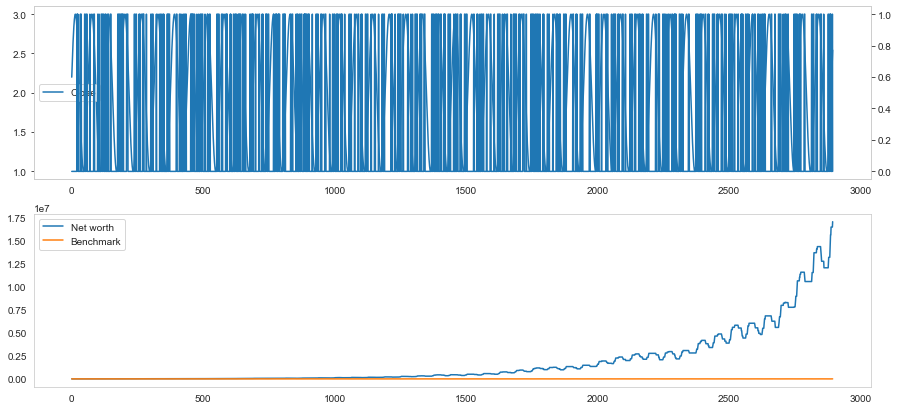

 11%|█         | 11/100 [00:27<03:38,  2.45s/it]

Episode Number: 12, Total return of episode: 739.5941556915925


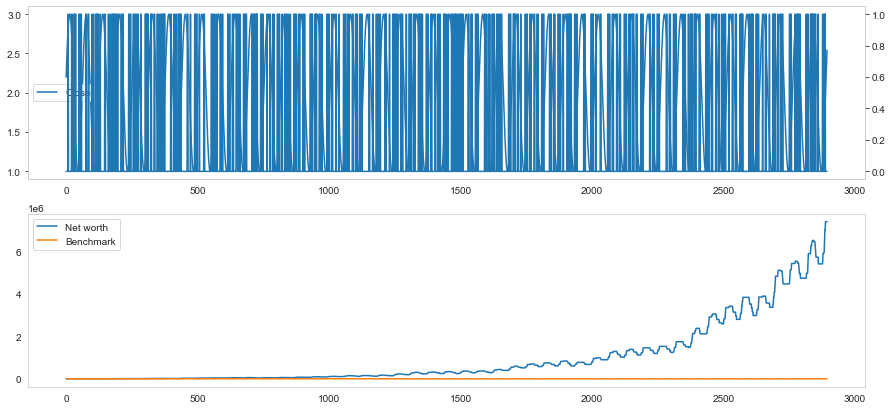

 12%|█▏        | 12/100 [00:29<03:34,  2.43s/it]

Episode Number: 13, Total return of episode: 1967.495964974314


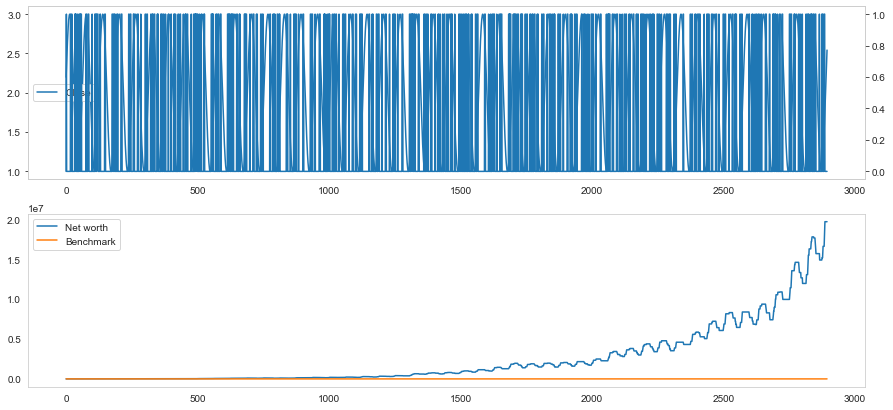

 13%|█▎        | 13/100 [00:31<03:31,  2.43s/it]

Episode Number: 14, Total return of episode: 79.61914543572509


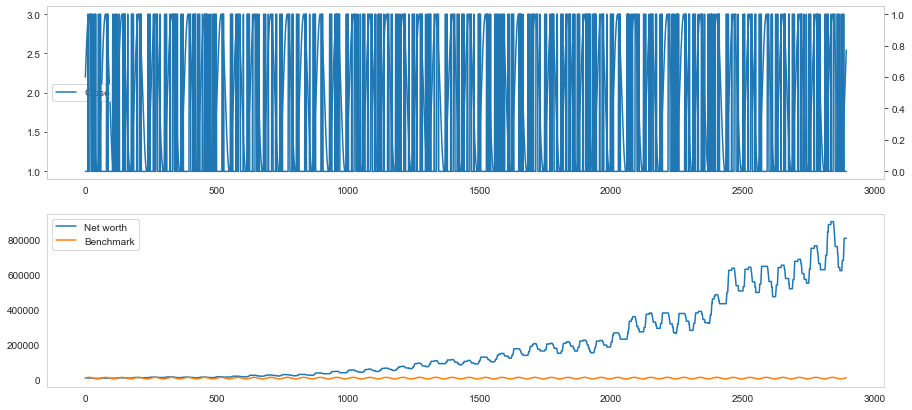

 14%|█▍        | 14/100 [00:35<03:35,  2.50s/it]


KeyboardInterrupt: 

In [44]:
model = train_q_learning(train_df, state_lookback, model, alpha, epsilon, gamma, episodes, all_states, all_actions, metric)

In [ ]:
eval_q_learning(test_df, model, state_lookback)
